# Getting Started - RocketPy in Colab

We start by setting up our environment. To run this notebook, we will need:


*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/giovaniceotto/RocketPy.git

In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [2]:
Env = Environment(
    rail_length=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [3]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [4]:
Env.set_atmospheric_model(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!


Gravity Details

Acceleration of Gravity at Lauch Site: 9.79111266229703 m/s²


Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2023-05-05 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 80.082 km
Forecast Time Period: From  2023-05-03 18:00:00  to  2023-05-19 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 4.54 m/s
Surface Wind Direction: 176.79°
Surface Wind Heading: 356.49°
Surface Pressure: 849.96 hPa
Surface Temperature: 284.68 K
Surface Air Density: 1.040 kg/m³
Surface Speed of Sound: 338.24 m/s


Atmospheric Model Plots



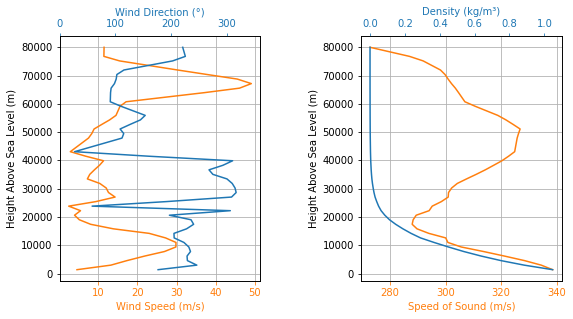

In [5]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

In [6]:
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    burn_out=3.9,
    grains_center_of_mass_position=-0.85704,
    grain_number=5,
    grain_separation=5 / 1000,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    nozzle_radius=33 / 1000,
    throat_radius=11 / 1000,
    interpolation_method="linear",
    nozzle_position=-1.255,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
#TODO check coordinate_system_orientation when input string is mispelled

The arguments *`nozzle_position`* and *`coordinate_system_orientation`* need to be handled with care since the coordinate system origin is chosen by the user. This means that *`nozzle_position`* is given with respect to an arbitrary reference. The definition of these arguments are really helpful:

- `coordinate_system_orientation` : *string, optional*

        Orientation of the motor's coordinate system. The coordinate system is
        defined by the motor's axis of symmetry. The origin of the coordinate
        system may be placed anywhere along such axis, such as at the nozzle area,
        and must be kept the same for all other positions specified.
        Options are "nozzleToCombustionChamber" and "combustionChamberToNozzle".
        Default is "nozzleToCombustionChamber".


- `nozzle_position` : *float, optional*

        Motor's nozzle outlet position in meters. More specifically, the coordinate
        of the nozzle outlet specified in the motor's coordinate system.
        Default is 0, in which case the origin of the motor's coordinate system
        is placed at the motor's nozzle outlet.

- `grains_center_of_mass_position` : *float*

        Position of the center of mass of the grains in meters. More specifically,
        the coordinate of the center of mass specified in the motor's coordinate


Here is a useful schematic for explanation:

![Motor orientation explanation](https://drive.google.com/uc?export=view&id=1jl5klD6EiRIS2zhgNBSrVKR8Sk_K9JXg)

In the Calisto example, the coordinate system origin we chose is at the center of dry mass of the rocket. Meaning the nozzle is 1.255 meters away from it. The minus sign comes from the `coordinate_system_orientation` argument, which is responsible for defining the positive direction of the coordinate system. Here is a representation of the reference used in Calisto:

<img src="https://drive.google.com/uc?export=view&id=1IamUZ-OGVFDRi7pP-VFWo5_B02VcFdOL" alt="Drawing" style="width: 500px;"/>

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allinfo method if you want more information all at once!


Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


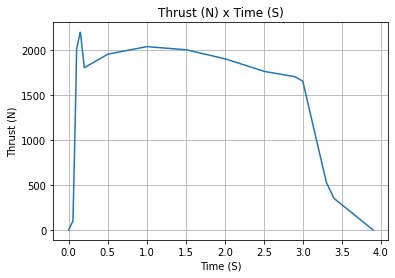

In [7]:
Pro75M1670.info()

### Creating a Rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named Calisto, entering inertia properties, some dimensions and drag curves. 

Here are some definitions that might prove useful. Check out the documentation for more.

- *`mass`* : *int, float*
        
        Unloaded rocket total mass (without propellant) in kg.

- *`inertia_i`* : *int, float*
        
        Unloaded rocket lateral (perpendicular to axis of symmetry)
        moment of inertia (without propellant) in kg m^2.

- *`inertia_z`* : *int, float*

        Unloaded rocket axial moment of inertia (without propellant) in kg m^2.

- *`power_off_drag`* : *int, float, callable, string, array*

        Rocket's drag coefficient when the motor is off.  If int or float
        is given, it is assumed constant. If callable, string or array is
        given, it must be a function of Mach number only.

- *`power_on_drag`* : *int, float, callable, string, array*

        Rocket's drag coefficient when the motor is on. If int or float is
        given, it is assumed constant. If callable, string or array is
        given, it must be a function of Mach number only.

In [8]:
Calisto = Rocket(
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertia_i=6.60,
    inertia_z=0.0351,
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_dry_mass_position=0,
    coordinate_system_orientation="tail_to_nose",
)

Calisto.set_rail_buttons([0.2, -0.5])

Rail buttons pair at positions 0.2 m and -0.5 m

Similar to the motor, the last two arguments, *`center_of_dry_mass_position`* and *`coordinate_system_orientation`*, need special care. Here, the coordinate system origin is chosen by the user. This means that *`center_of_dry_mass_position`* is given with respect to an arbitrary reference. *`coordinate_system_orientation`*.
The definitions are also helpful:

- `coordinate_system_orientation` : *string, optional*

        String defining the orientation of the rocket's coordinate system. The
        coordinate system is defined by the rocket's axis of symmetry. The system's
        origin may be placed anywhere along such axis and must be kept the same for
        all other positions specified.
        The two options available are: "tailToNose" and "noseToTail". The first
        defines the coordinate system with the rocket's axis of symmetry pointing
        from the rocket's tail to the rocket's nose cone. The second option defines
        the coordinate system with the rocket's axis of symmetry pointing from the
        rocket's nose cone to the rocket's tail. Default is "tailToNose".


- `center_of_dry_mass_position` : *int, float, optional*

        Position, in m, of the rocket's center of dry mass (i.e. center of mass
        without propellant) relative to the rocket's coordinate system.
        Default is 0, which means the center of dry mass is chosen as the origin.



And a schematic for explanation:

![Rocket orientation explanation](https://drive.google.com/uc?export=view&id=1eEIHobK9gPyL0sgr8vH7EZZtS2Rgs10E)

In the Calisto example, the coordinate system origin we chose is at the center of dry mass of the rocket. Meaning the nozzle is 1.255 meters away from it. The minus sign comes from the `coordinate_system_orientation` argument, which is responsible for defining the positive direction of the coordinate system. The positions of the motor, the fins, the nose cone, and the tail must also be given by 

<img src="https://drive.google.com/uc?export=view&id=1Z64YTavVbUWq-qX28EJgcBQPCPcxeDYW" alt="Drawing" style="width: 600px;"/>

It is important to note that the position of the origin of the coordinate system can be anywhere, as long as all positions are given coherently. This means that you could input all positions based on the nosecone's tip, or based on the coordinates of a CAD model.

To add the motor to our rocket we need only inform what motor we are adding (Pro75M1670) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.

In [9]:
Calisto.add_motor(Pro75M1670, position=-1.255)

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the nose cone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

In [11]:
nosecone = Calisto.add_nose(length=0.55829, kind="vonKarman", position=0.71971 + 0.55829)

finset = Calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.040,
    span=0.100,
    position=-1.04956,
    cant_angle=0,
    radius=None,
    airfoil=None,
)

tail = Calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

To see all information regarding the rocket we just defined we run:


Inertia Details

Rocket Mass: 16.241 kg (No Propellant)
Rocket Mass: 19.197 kg (With Propellant)
Rocket Inertia I: 6.600 kg*m2
Rocket Inertia Z: 0.035 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Dry Mass - Nozzle Exit Distance: 1.255 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.857 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.132 m

Aerodynamic Components Parameters
Currently not implemented.


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.145/rad
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.145/rad
Tail Lift Coefficient Derivative: -1.061/rad

Aerodynamics Center of Pressure

Nose Cone Center of Pressure to CM: 0.279 m
Fins Center of Pressure to CM: 0.055 m
Nose Cone Center of Pressure to CM: 0.279 m
Fins Center of Pressure to CM: 0.055 m
Tail Center 

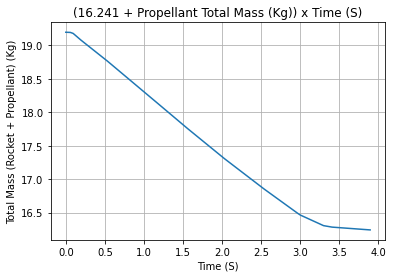

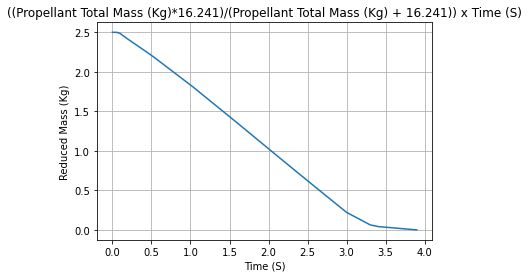


Aerodynamics Plots


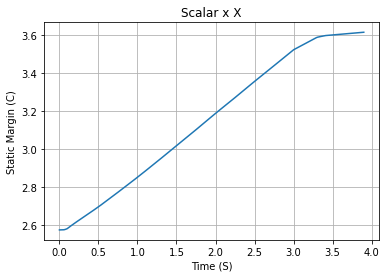

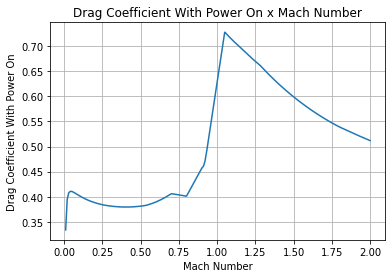

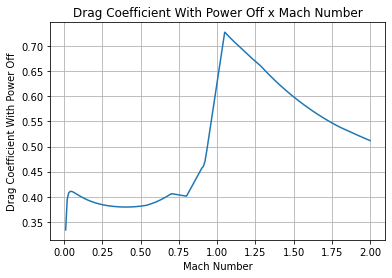

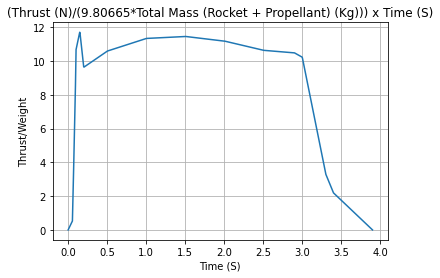

In [12]:
Calisto.allinfo()

#### Adding Parachutes

Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also receives the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

In [13]:
def drogue_trigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def main_trigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


Main = Calisto.add_parachute(
    "Main",
    CdS=10.0,
    trigger=main_trigger,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = Calisto.add_parachute(
    "Drogue",
    CdS=1.0,
    trigger=drogue_trigger,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```

## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.

In [14]:
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 4.53 m/s
Lateral Surface Wind Speed: 0.25 m/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.363 s
Rail Departure Velocity: 25.802 m/s
Rail Departure Static Margin: 2.658 c
Rail Departure Angle of Attack: 10.115°
Rail Departure Thrust-Weight Ratio: 10.143
Rail Departure Reynolds Number: 1.922e+05


BurnOut State

BurnOut time: 3.900 s
Altitude at burnOut: 660.551 m (AGL)
Rocket velocity at burnOut: 280.205 m/s
Freestream velocity at burnOut: 280.300 m/s
Mach Number at burnOut: 0.830
Kinetic energy at burnOut: 6.376e+05 J


Apogee S

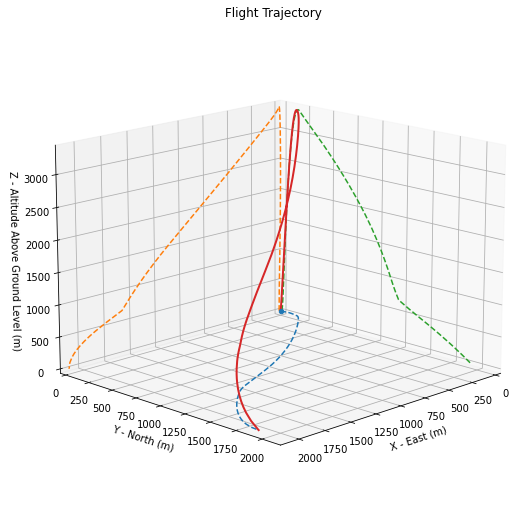



Trajectory Kinematic Plots



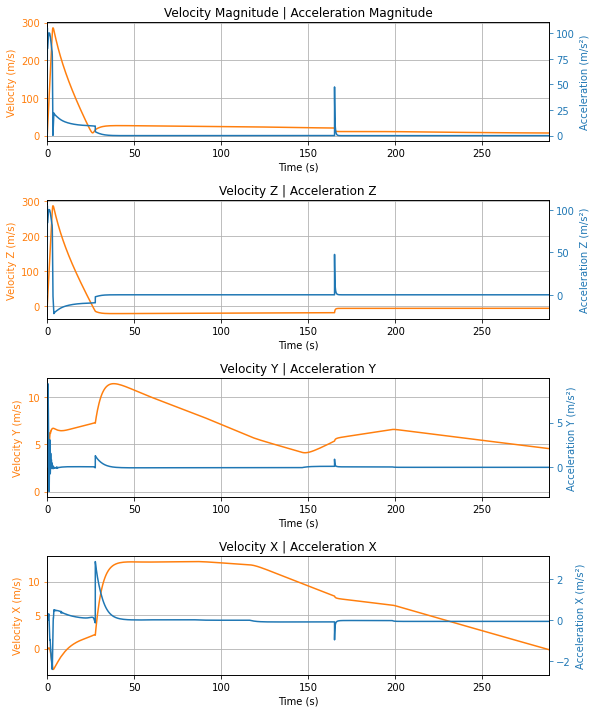



Angular Position Plots



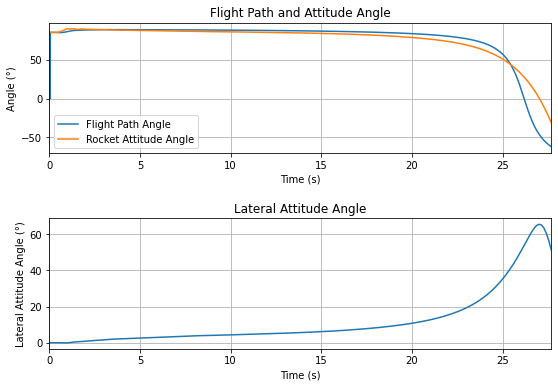



Path, Attitude and Lateral Attitude Angle plots



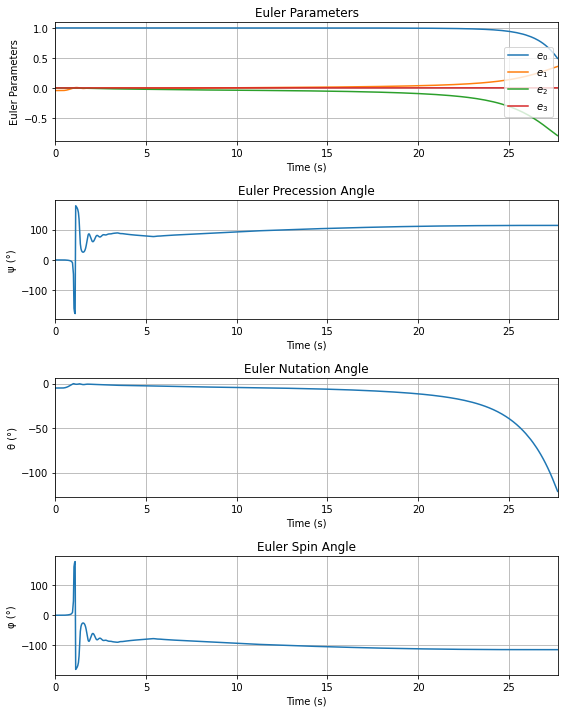



Trajectory Angular Velocity and Acceleration Plots



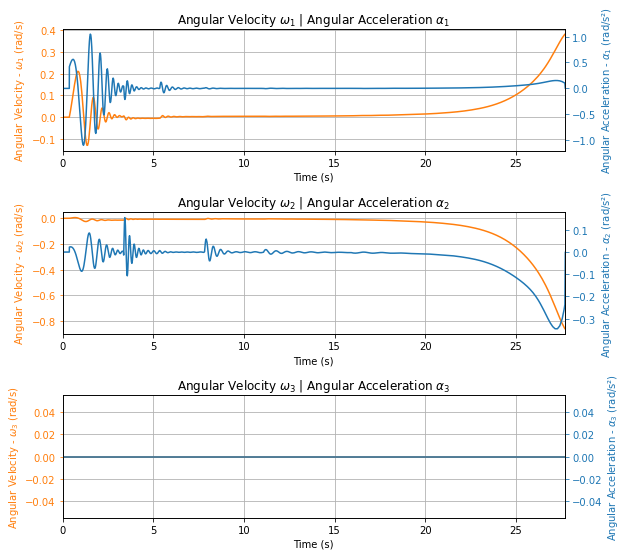



Trajectory Force Plots



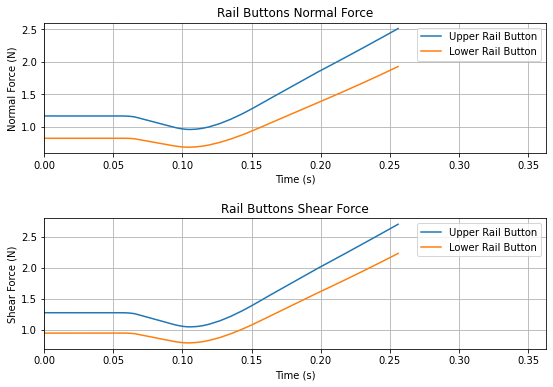

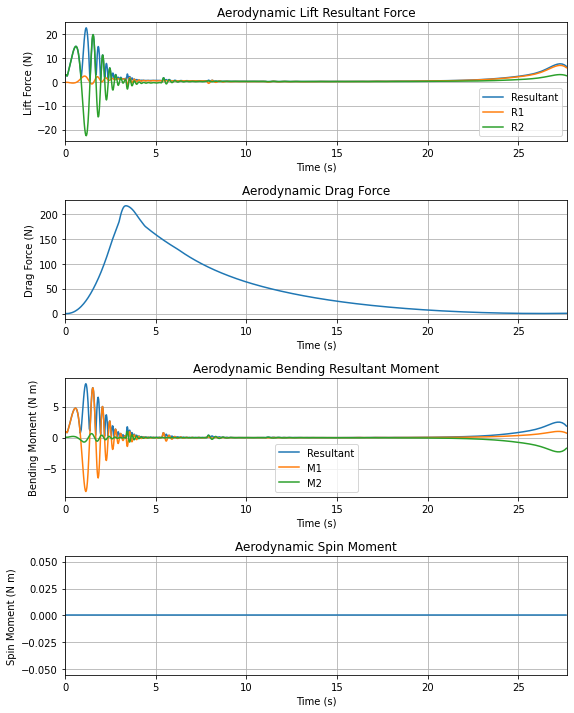



Trajectory Energy Plots



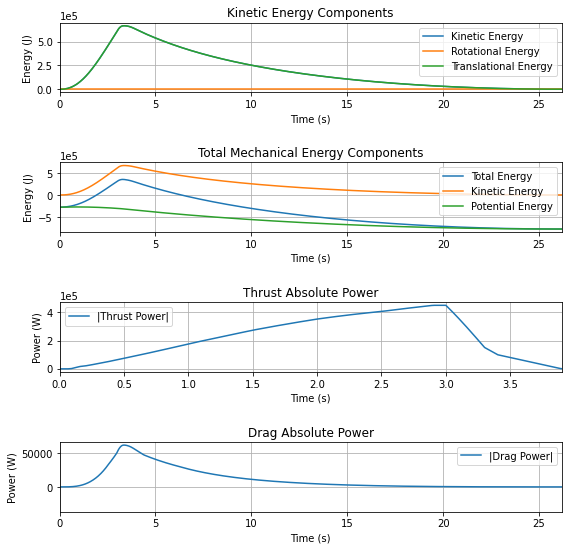



Trajectory Fluid Mechanics Plots



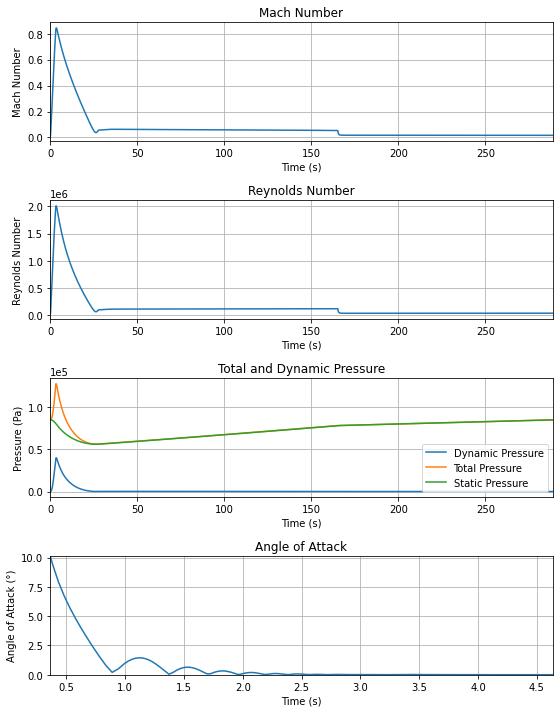



Trajectory Stability and Control Plots



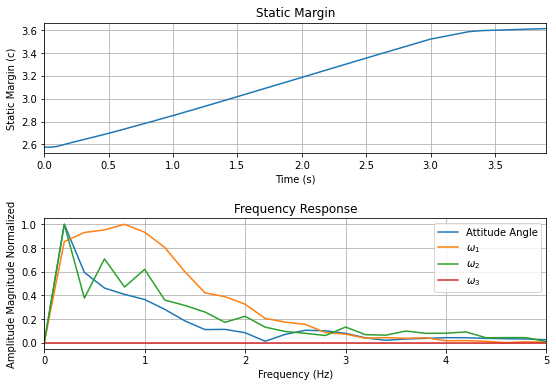



Rocket and Parachute Pressure Plots



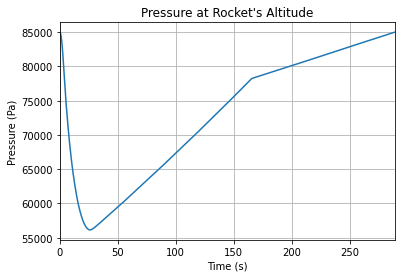


Parachute:  Main


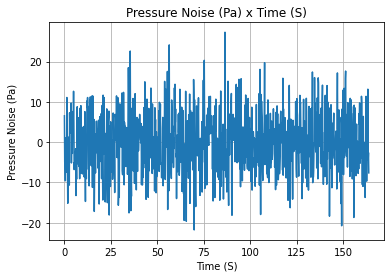

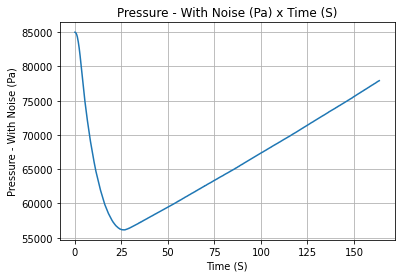

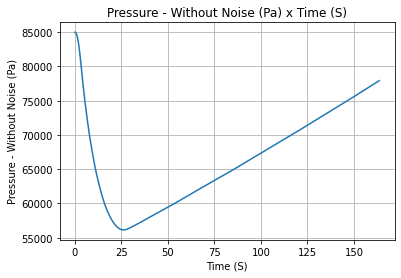


Parachute:  Drogue


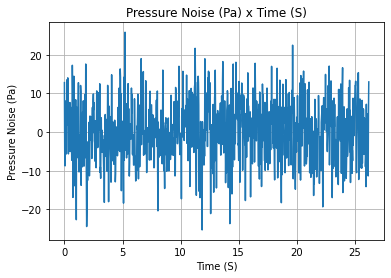

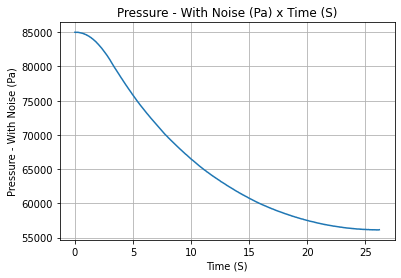

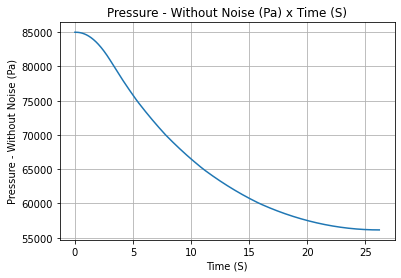

In [15]:
TestFlight.allinfo()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth

In [18]:
TestFlight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relativetoground",
)

File  trajectory.kml  saved with success!


## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.

Simulating Rocket with Static Margin of -1.444->-0.405 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -0.046->0.993 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 1.352->2.391 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 2.750->3.789 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 4.147->5.186 c
Simulation Completed at Time: 5.0000 s


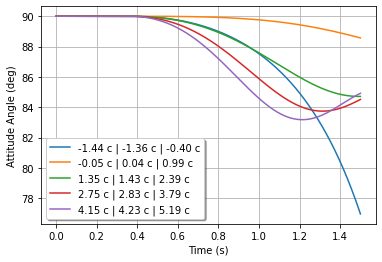

In [21]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
Calisto = Rocket(
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertia_i=6.60,
    inertia_z=0.0351,
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_dry_mass_position=0,
    coordinate_system_orientation="tail_to_nose",
)

Calisto.set_rail_buttons([0.2, -0.5])

Calisto.add_motor(Pro75M1670, position=-1.255)

nosecone = Calisto.add_nose(length=0.55829, kind="vonKarman", position=0.71971 + 0.55829)

finset = Calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.040,
    span=0.100,
    position=-1.04956,
    cant_angle=0,
    radius=None,
    airfoil=None,
)
tail = Calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

# Prepare Environment Class
Env = Environment(5.2, 9.8)
Env.set_atmospheric_model(type="CustomAtmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.5, 0.7, 0.9, 1.1, 1.3]:
    # Modify rocket fin set by removing previous one and adding new one
    Calisto.aerodynamic_surfaces.remove((finset,finset.position))
    finset = Calisto.add_trapezoidal_fins(
    4, span=0.100, root_chord=0.120, tip_chord=0.040, position=-1.04956*factor
)
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            Calisto.static_margin(0), Calisto.static_margin(Calisto.motor.burn_out_time)
        )
    )
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.post_process()
    # Store Results
    static_margin_at_ignition = Calisto.static_margin(0)
    static_margin_at_out_of_rail = Calisto.static_margin(TestFlight.out_of_rail_time)
    static_margin_at_steady_state = Calisto.static_margin(TestFlight.t_final)
    simulation_results += [
        (
            TestFlight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allinfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

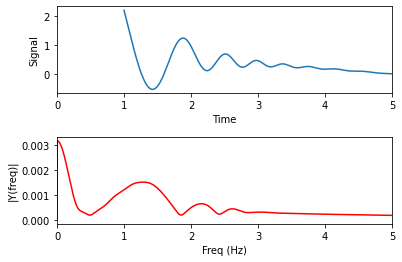

In [24]:
import numpy as np
import matplotlib.pyplot as plt

Env = Environment(
    rail_length=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

Env.set_atmospheric_model(type="CustomAtmosphere", wind_v=-5)

# Prepare Motor
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    burn_out=3.9,
    grains_center_of_mass_position=-0.85704,
    grain_number=5,
    grain_separation=5 / 1000,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    nozzle_radius=33 / 1000,
    throat_radius=11 / 1000,
    interpolation_method="linear",
    nozzle_position=-1.255,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

# Prepare Rocket
Calisto = Rocket(
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertia_i=6.60,
    inertia_z=0.0351,
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_dry_mass_position=0,
    coordinate_system_orientation="tail_to_nose",
)

Calisto.set_rail_buttons([0.2, -0.5])

Calisto.add_motor(Pro75M1670, position=-1.255)

nosecone = Calisto.add_nose(length=0.55829, kind="vonKarman", position=0.71971 + 0.55829)

finset = Calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.040,
    span=0.100,
    position=-1.04956,
    cant_angle=0,
    radius=None,
    airfoil=None,
)

tail = Calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

# Simulate first 5 seconds of Flight
TestFlight = Flight(
    rocket=Calisto,
    environment=Env,
    inclination=90,
    heading=0,
    max_time_step=0.01,
    max_time=5,
)
TestFlight.post_process()

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = TestFlight.attitude_angle(t) - np.mean(TestFlight.attitude_angle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

#TODO ask gio about this cell

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.

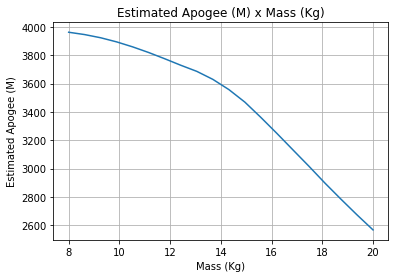

In [26]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(
        rail_length=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.set_atmospheric_model(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrust_source="../../data/motors/Cesaroni_M1670.eng",
        burn_out=3.9,
        grains_center_of_mass_position=-0.85704,
        grain_number=5,
        grain_separation=5 / 1000,
        grain_density=1815,
        grain_outer_radius=33 / 1000,
        grain_initial_inner_radius=15 / 1000,
        grain_initial_height=120 / 1000,
        nozzle_radius=33 / 1000,
        throat_radius=11 / 1000,
        interpolation_method="linear",
        nozzle_position=-1.255,
        coordinate_system_orientation="nozzle_to_combustion_chamber",
    )

    # Prepare Rocket
    Calisto = Rocket(
        radius=127 / 2000,
        mass=mass,
        inertia_i=6.60,
        inertia_z=0.0351,
        power_off_drag="../../data/calisto/powerOffDragCurve.csv",
        power_on_drag="../../data/calisto/powerOnDragCurve.csv",
        center_of_dry_mass_position=0,
        coordinate_system_orientation="tail_to_nose",
    )

    Calisto.set_rail_buttons([0.2, -0.5])

    Calisto.add_motor(Pro75M1670, position=-1.255)

    nosecone = Calisto.add_nose(length=0.55829, kind="vonKarman", position=0.71971 + 0.55829)

    finset = Calisto.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956,
        cant_angle=0,
        radius=None,
        airfoil=None,
    )

    tail = Calisto.add_tail(
        top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=85,
        heading=0,
        terminate_on_apogee=True,
    )
    return TestFlight.apogee - Env.elevation


apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8, 20, 20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

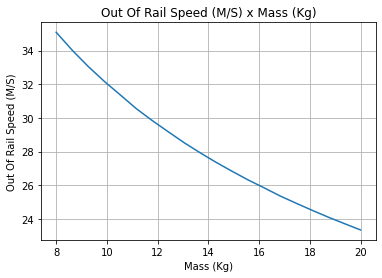

In [27]:
def speed(mass):
    # Prepare Environment
    Env = Environment(
        rail_length=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.set_atmospheric_model(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrust_source="../../data/motors/Cesaroni_M1670.eng",
        burn_out=3.9,
        grains_center_of_mass_position=-0.85704,
        grain_number=5,
        grain_separation=5 / 1000,
        grain_density=1815,
        grain_outer_radius=33 / 1000,
        grain_initial_inner_radius=15 / 1000,
        grain_initial_height=120 / 1000,
        nozzle_radius=33 / 1000,
        throat_radius=11 / 1000,
        interpolation_method="linear",
        nozzle_position=-1.255,
        coordinate_system_orientation="nozzle_to_combustion_chamber",
    )

    # Prepare Rocket
    Calisto = Rocket(
        radius=127 / 2000,
        mass=mass,
        inertia_i=6.60,
        inertia_z=0.0351,
        power_off_drag="../../data/calisto/powerOffDragCurve.csv",
        power_on_drag="../../data/calisto/powerOnDragCurve.csv",
        center_of_dry_mass_position=0,
        coordinate_system_orientation="tail_to_nose",
    )

    Calisto.set_rail_buttons([0.2, -0.5])

    Calisto.add_motor(Pro75M1670, position=-1.255)

    nosecone = Calisto.add_nose(
        length=0.55829, kind="vonKarman", position=0.71971 + 0.55829
    )

    finset = Calisto.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956,
        cant_angle=0,
        radius=None,
        airfoil=None,
    )

    tail = Calisto.add_tail(
        top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=85,
        heading=0,
        terminate_on_apogee=True,
    )
    return TestFlight.out_of_rail_velocity


speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8, 20, 20)
